In [22]:
# Imports
import os, warnings
import librosa
import numpy as np
import tensorflow as tf
import soundfile as sf
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.io import wavfile
from scipy import signal, fftpack
from collections import defaultdict
from testing_functions import test_hss
from process_functions import preprocessing_audio
from utils import find_and_open_audio, signal_segmentation, get_resp_segments
from heart_sound_segmentation.filter_and_sampling import downsampling_signal, \
    upsampling_signal
from source_separation.descriptor_functions import get_spectrogram
from IPython.display import Audio
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing, linear_model, svm
from sklearn.metrics import confusion_matrix, accuracy_score
from pybalu.feature_selection import sfs
from pybalu.feature_transformation import normalize

# Funciones previas

In [2]:
# Funciones de características
def get_filterbanks(N, samplerate, freq_lim, n_filters, norm_exp=1,
                    scale_type='mel', filter_type='triangular',
                    norm_filters=True, plot_filterbank=False):
    '''Función que permite obtener un banco de filtros linealmente
    espaciados o espaciados en frecuencia de mel para calcular
    coeficientes cepstrales.
    
    Parameters
    ----------
    N : ndarray
        Largo de la señal.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_filters : int
        Cantidad de filtros a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''
    def _freq_to_bin(f):
        # Definición del bin correspondiente en la definición
        # del intervalo de cálculo. Se usa (N - 1) ya que los bins
        # se definen entre 0 y (N - 1) (largo N)
        return np.rint(f / samplerate * (N - 1)).astype(int)
    
    
    def _triangular_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i] + 1] = \
                np.linspace(0, 1, abs(bins_points[i] - bins_points[i - 1] + 1))
            
            # Tramo descendente del filtro triangular
            filter_bank[i - 1][bins_points[i]:bins_points[i + 1] + 1] = \
                np.linspace(1, 0, abs(bins_points[i + 1] - bins_points[i] + 1))
            
        return filter_bank
    
    
    def _hanning_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = \
                np.hanning(abs(bins_points[i + 1] - bins_points[i - 1] + 1))
        
        return filter_bank
    
    
    def _squared_filter(bins_points):
        # Definición del banco de filtros
        filter_bank = np.zeros((n_filters, N))
        
        for i in range(1, n_filters + 1):
            # Tramo ascendente del filtro triangular
            filter_bank[i - 1][bins_points[i - 1]:bins_points[i + 1] + 1] = 1
        
        return filter_bank
    
    
    def _norm_filterbank(filter_bank):
        # Definición del banco de filtros de salida
        filter_bank_out = np.zeros((n_filters, N))
        
        # Normalizar los filtros a energía 1
        for i in range(n_filters):
            filter_bank_out[i] = filter_bank[i] / \
                                 sum(filter_bank[i] ** norm_exp)
            
        return filter_bank_out
    
    
    # Definición de los bines en base a las frecuencias de cada filtro
    if scale_type == 'linear':
        # Definición de las "n_filters" frecuencias equiespaciadas entre
        # 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya que se 
        # necesitan para definir los límites de los filtros.
        freqs = np.arange(0, (n_filters + 1) + 1) * freq_lim / (n_filters + 1)
    
    
    elif scale_type == 'mel':
        # Definición del límite en frecuencias de mel (para no pasarse del
        # freq_lim al devolverse)
        mel_freq_lim = 2595 * np.log10(1 + freq_lim / 700)
        
        # Definición de las "n_filters" frecuencias espaciadas en escala mel 
        # entre 0 y freq_lim. Se le agregan 2 puntos (0 y el freq_lim) ya 
        # que se necesitan para definir los límites de los filtros.
        mel_freqs = np.arange(0, (n_filters + 1) + 1) * mel_freq_lim / (n_filters + 1)
        
        # Transformando de intervalos equi espaciados usando la escala
        # de mel. Es necesario hacer la transformación inversa ya que
        # en este caso se dice que lo equi espaciado viene de mel
        freqs = 700 * (10 ** (mel_freqs / 2595) - 1)
    
    else:
        raise Exception('Opción de tipo de coeficiente cepstral no válido.')
    
    
    # Transformando a bins
    bins_to = _freq_to_bin(freqs)
    
    
    # Obtención del banco de filtros
    if filter_type == 'triangular':
        filter_bank = _triangular_filter(bins_to)
        
    if filter_type == 'hanning':
        filter_bank = _hanning_filter(bins_to)
    
    elif filter_type == 'squared':
        filter_bank = _squared_filter(bins_to)
    
    # Normalizar por la energía de la señal
    if norm_filters:
        filter_bank = _norm_filterbank(filter_bank)
    
    
    # Gráfico del banco de filtros
    if plot_filterbank:
        plt.figure()
        
        # Definición del vector de frecuencias
        f_plot = np.arange(N) * samplerate / N
        
        for i in range(n_filters):
            plt.plot(filter_bank[i])
            # plt.plot(f_plot, filter_bank[i])

        for i in bins_to:
            # plt.axvline(i * samplerate / N, c='silver', linestyle=':')
            plt.axvline(i, c='silver', linestyle=':')
            
        # plt.xlim([0, freq_lim])
        plt.xlim([0, bins_to[-1]])
        plt.show()
    
    
    return filter_bank


def get_cepstral_coefficients(signal_in, samplerate, spectrogram_params,
                              freq_lim, n_filters, n_coefs, scale_type='mel', 
                              filter_type='triangular', inverse_func='dct', 
                              norm_filters=True, plot_filterbank=False, 
                              power=2):
    '''Función que permite obtener los coeficientes cepstrales a partir de 
    un banco de filtros.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(spectrogram_params['N'], samplerate, 
                                  freq_lim=freq_lim, n_filters=n_filters, 
                                  scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Obtener el espectrograma de la señal
    t, f, S = get_spectrogram(signal_in, samplerate, N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=True)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(S) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    energy_coefs = np.dot(filter_bank, energy_spectrum)
    
    # Aplicando el logaritmo
    energy_coefs = np.log(energy_coefs + 1e-10)
    
    # Calculando los coeficientes cepstrales
    if inverse_func == 'dct':
        cepstral_coefs = fftpack.dct(energy_coefs, norm='ortho', axis=0)
    elif inverse_func == 'idft':
        cepstral_coefs = np.fft.ifft(energy_coefs, axis=-1).real
    else:
        raise Exception('Opción de tipo de función inversa no válida.')
    
    
    return cepstral_coefs[:n_coefs]


def get_bands_coefficients(signal_in, samplerate, spectrogram_params,
                           freq_lim, n_coefs, scale_type='mel', 
                           filter_type='triangular', norm_filters=True, 
                           plot_filterbank=False, 
                           power=2):
    '''Función que permite obtener la energía por bandas de frecuencia
    a partir de un banco de filtros.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    freq_lim : float
        Frecuencia límite para calcular los coeficientes cepstrales.
    n_coefs : int
        Cantidad de coeficientes a obtener.
    scale_type : {'mel', 'linear'}, optional
        Tipo de espaciado entre los bancos de filtros para el cálculo
        de los coeficientes cepstrales. Por defecto es 'mel' (MFCC). 
    filter_type : {'triangular', 'hanning', 'squared'}, optional
        Forma del filtro a utilizar para el cálculo de la energía en 
        cada banda. Por defecto es 'triangular'.
    inverse_func : {'dct', 'idft'}, optional
        Función a utilizar para obtener los coeficientes cepstrales.
        Por defecto es 'dct'.
    plot_filterbank : bool, optional
        Booleano que indica si se grafica el banco de filtros. Por 
        defecto es False.
    
    References
    ----------
    [1] http://practicalcryptography.com/miscellaneous/machine-learning/
        guide-mel-frequency-cepstral-coefficients-mfccs/
    [2] Xuedong Huang, Alex Acero, Hsiao-Wuen Hon - Spoken Language 
        Processing A Guide to Theory, Algorithm and System 
        Development-Prentice Hall PTR (2001)
    '''    
    # Definición de la cantidad de puntos a considerar
    filter_bank = get_filterbanks(spectrogram_params['N'], samplerate, 
                                  freq_lim=freq_lim, 
                                  n_coefs=n_coefs, scale_type=scale_type, 
                                  filter_type=filter_type,
                                  norm_filters=norm_filters, 
                                  plot_filterbank=plot_filterbank)
    
    # Obtener el espectrograma de la señal
    t, f, S = get_spectrogram(signal_in, samplerate, N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=True)
    
    # Definición del espectro de la señal
    energy_spectrum = np.abs(S) ** power
    
    # Se aplica el banco de filtros sobre el espectro de la señal
    energy_coefs = np.dot(filter_bank, energy_spectrum)
    
    return energy_coefs


def get_energy_bands(signal_in, samplerate, spectrogram_params, 
                     fmin=0, fmax=1000, fband=20, power=2):
    '''Función que permite definir un espectrograma en bandas de 
    energía.
    
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    spectrogram_params : dict
        Parámetros del espectrograma.
    fmin : float, optional
        Frecuencia mínima a considerar en el intervalo de interés.
        Por defecto es 0.
    fmax : float, optional
        Frecuencia máxima a considerar en el intervalo de interés.
        Este valor no puede mayor a samplerate / 2. Por defecto 
        es 1000.
    fband : float, optional
        Ancho de cada banda de frecuencia entre fmin y fmax. Por 
        defecto es 20.
    power : float, optional
        Exponente con el que se calcula la energía.
    
    Returns
    -------
    energy_S : ndarray
        Bandas de energía a través del tiempo (formato 
        espectrograma) con dimensión (#bandas x #bins de tiempo 
        del espectrograma).     
    '''
    # Obtener el espectrograma
    t, f, S = get_spectrogram(signal_in, samplerate, 
                              N=spectrogram_params['N'], 
                              padding=spectrogram_params['padding'], 
                              repeat=spectrogram_params['repeat'], 
                              noverlap=spectrogram_params['noverlap'], 
                              window=spectrogram_params['window'], 
                              whole=False)
    
    # Definición de los intervalos
    f_intervals = np.arange(fmin, fmax, fband)

    # Definición de la lista que almacenará los datos
    energy_band = np.zeros(len(f_intervals) - 1)
    energy_S = np.zeros((len(energy_band), len(t)))

    for i in range(len(f_intervals) - 1):
        lower_lim = f_intervals[i]
        upper_lim = f_intervals[i + 1]

        # Definición de los índices de interés
        indexes = np.where((lower_lim <= f) & (f <= upper_lim))[0]

        # Definiendo el valor
        energy_S[i] = np.sum(abs(S[indexes,:]) ** power, axis=0)
    
    return energy_S


In [3]:
def _conditioning_signal(signal_in, samplerate, samplerate_to):
    # Acondicionando en caso de que no tenga samplerate de 1000 Hz.
    if samplerate < samplerate_to:
        print(f'Upsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.') 
        new_rate = samplerate_to           
        audio_to = upsampling_signal(signal_in, samplerate, new_samplerate=new_rate)

    elif samplerate > samplerate_to:
        print(f'Downsampling de la señal de fs = {samplerate} Hz '
              f'a fs = {samplerate_to} Hz.')
        new_rate, audio_to = downsampling_signal(signal_in, samplerate, 
                                                 freq_pass=samplerate_to//2-100, 
                                                 freq_stop=samplerate_to//2)

    else:
        print(f'Samplerate adecuado a fs = {samplerate} Hz.')
        audio_to = signal_in
        new_rate = samplerate_to

    # Mensaje para asegurar
    print(f'Señal acondicionada a {new_rate} Hz para la separación de fuentes.')

    # Asegurándose de que el largo de la señal sea par
    if len(audio_to) % 2 != 0:
        audio_to = np.concatenate((audio_to, [0]))

    return audio_to, new_rate

In [4]:
def pybalu_clean(features, tol=1e-8, show=False):
    n_features = features.shape[1]
    ip = np.ones(n_features, dtype=int)

    # cleaning correlated features
    warnings.filterwarnings('ignore')
    C = np.abs(np.corrcoef(features, rowvar=False))
    idxs = np.vstack(np.where(C > .99))
    
    # remove pairs of same feature ( feature i will have a correlation of 1 whit itself )
    idxs = idxs[:, idxs[0,:] != idxs[1,:]]
    
    # remove correlated features
    if idxs.size > 0:
        ip[np.max(idxs, 0)] = 0
    
    # remove constant features
    s = features.std(axis=0, ddof=1)
    ip[s < tol] = 0
    p = np.where(ip.astype(bool))[0]

    if show:
        print(f'Clean: number of features reduced from {n_features} to {p.size}.')

    return p

# Parámetros de los descriptores

In [6]:
# Parámetro base de datos
preprocess = True

# Parámetros de los espectrogramas generales
N = 1024
noverlap = int(0.9 * N)
spec_params = {'N': N, 'noverlap': noverlap, 'window': 'hann', 
               'padding': 0, 'repeat': 0}

# Parámetros MFCC
mfcc_params = {'n_mfcc': 50, 'n_filters': 50, 'spec_params': spec_params,
               'freq_lim': 2000, 'norm_filters': True, 'power': 2}
lfcc_params = {'n_mfcc': 50, 'n_filters': 50, 'spec_params': spec_params,
               'freq_lim': 2000, 'norm_filters': True, 'power': 2}
energy_params = {'spec_params': spec_params, 'fmin': 0, 'fmax': 1000, 
                 'fband': 20}

In [32]:
# Dirección de la base de datos
db_original = 'C:/Users/Chris/Desktop/Scripts_Magister/Respiratory_Sound_Database/audio_and_txt_files'
db_folder = 'unpreprocessed_signals'

# Nombres de los archivos
filenames = [i[:-4] for i in os.listdir(db_folder) if i.endswith('.wav') and not 'Tc' in i]

# Extracción de características

In [33]:
%matplotlib notebook

# Definición de los arrays donde se acumulará las características
X_data = list()

# Definición de los arrays donde se acumularán las etiquetas
Y_wheeze = list()
Y_crackl = list()

# Diccionario que indica los segmentos que corresponden a cada paciente
patient_register = defaultdict(list)

# Contador de los segmentos
seg_i = 0

# Definición de una lista auxiliar de sanidad
segments_register = list()


# Nombre del archivo .wav a utilizar
for num, name in enumerate(filenames):
    print(f'Iteración {num + 1}: {name}')
    print(f'--------------------------')
    
    # Definición del paciente de interés
    patient = name.split('_')[0]
    
    if preprocess:
        filename = f'{db_folder}/{name}'
    else:
        filename = f'{db_original}/{name}'

    # Cargando el archivo
    try:
        samplerate, resp_signal = wavfile.read(f'{filename}.wav')
    except:
        resp_signal, samplerate = sf.read(f'{filename}.wav')
    
    print(f'Samplerate = {samplerate}, largo = {resp_signal.shape}')
    
    # Normalizando
    resp_signal = resp_signal / max(abs(resp_signal))
    
    
    # Obteniendo la información de los segmentos de este archivo de audio
    name_txt = '_'.join(name.split('_')[:-1])
    resp_list_info = get_resp_segments(resp_signal, samplerate, 
                                       filepath=f'{db_original}/{name_txt}.txt')
    
    segments_register.append((name, len(resp_list_info)))
    
    # Para cada segmento, se obtiene la información de interés
    for resp_info in resp_list_info:
        # Registrando
        patient_register[patient].append(seg_i)
        seg_i += 1
                
        ### Calculando las características a partir del segmento ###
        
        # Cálculo del MFCC
        mfcc_features = \
            get_cepstral_coefficients(resp_info[0], samplerate, 
                                      spectrogram_params=mfcc_params['spec_params'],
                                      freq_lim=mfcc_params['freq_lim'], 
                                      n_filters=mfcc_params['n_filters'], 
                                      n_coefs=mfcc_params['n_mfcc'], 
                                      scale_type='mel', 
                                      filter_type='triangular', inverse_func='dct', 
                                      norm_filters=mfcc_params['norm_filters'], 
                                      plot_filterbank=False, 
                                      power=mfcc_params['power'])
                
        # Cálculo del LFCC
        lfcc_features = \
            get_cepstral_coefficients(resp_info[0], samplerate, 
                                      spectrogram_params=lfcc_params['spec_params'],
                                      freq_lim=lfcc_params['freq_lim'], 
                                      n_filters=lfcc_params['n_filters'], 
                                      n_coefs=lfcc_params['n_mfcc'], 
                                      scale_type='linear', 
                                      filter_type='triangular', inverse_func='dct', 
                                      norm_filters=lfcc_params['norm_filters'], 
                                      plot_filterbank=False, 
                                      power=lfcc_params['power'])
        
        # Cálculo de la energía por bandas
        energy_S = \
            get_energy_bands(resp_info[0], samplerate,
                             spectrogram_params=energy_params['spec_params'],
                             fmin=energy_params['fmin'], 
                             fmax=energy_params['fmax'], 
                             fband=energy_params['fband'])
        
        # Colapsando la información
        to_append = np.concatenate((mfcc_features.mean(axis=1),
                                 lfcc_features.mean(axis=1),
                                 20 * np.log10(energy_S.mean(axis=1))), axis=0)
        
        # Agregando la información a cada arreglo
        X_data.append(to_append)
        
        Y_crackl.append(resp_info[1])
        Y_wheeze.append(resp_info[2])


# Transformando listas a arrays
X_data = np.array(X_data)

Y_wheeze = np.array(Y_wheeze)
Y_crackl = np.array(Y_crackl)

Iteración 1: 101_1b1_Al_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 2: 101_1b1_Pr_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 3: 102_1b1_Ar_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 4: 103_2b2_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 5: 104_1b1_Al_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (63424,)
Iteración 6: 104_1b1_Ar_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (102336,)
Iteración 7: 104_1b1_Ll_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (73920,)
Iteración 8: 104_1b1_Lr_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (60096,)
Iteración 9: 104_1b1_Pl_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (91840,)
Iteración 10: 104_1b1_Pr_sc_Litt3200_4000
-----------------

--------------------------
Samplerate = 4000, largo = (269600,)
Iteración 79: 122_2b1_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 80: 122_2b1_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 81: 122_2b2_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 82: 122_2b2_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 83: 122_2b3_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 84: 122_2b3_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 85: 123_1b1_Al_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 86: 124_1b1_Al_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (50112,)
Iteración 87: 124_1b1_Ar_sc_Litt3200_4000
--------------------------
Samplerate = 4000, l

Iteración 155: 133_2p2_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 156: 133_2p2_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 157: 133_2p2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 158: 133_2p3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 159: 133_2p3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 160: 133_2p3_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 161: 133_2p3_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 162: 133_2p4_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 163: 133_2p4_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 164: 133_2p4_Pl_mc_AKGC417L

--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 232: 145_2b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 233: 145_3b2_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 234: 145_3b2_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 235: 145_3b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 236: 146_2b2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 237: 146_2b4_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 238: 146_2b4_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 239: 146_2b4_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 240: 146_2b4_Lr_mc_AKGC417L_44100
--------------------------
Samplerate

Samplerate = 4410, largo = (88200,)
Iteración 308: 154_4b4_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 309: 154_4b4_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 310: 154_4b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 311: 154_4b4_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 312: 155_2b1_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 313: 156_2b3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 314: 156_2b3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 315: 156_2b3_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 316: 156_2b3_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
I

Iteración 384: 162_1b2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 385: 162_1b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 386: 162_2b2_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 387: 162_2b2_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 388: 162_2b2_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 389: 162_2b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 390: 162_2b3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 391: 162_2b3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 392: 162_2b3_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 393: 162_2b3_Pl_mc_AKGC417L

--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 461: 172_1b5_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 462: 172_1b5_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 463: 172_1b5_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 464: 172_1b5_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 465: 172_1b5_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 466: 172_2b5_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 467: 172_2b5_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 468: 172_2b5_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 469: 172_2b5_Pl_mc_AKGC417L_44100
--------------------------
Samplerate

Iteración 537: 178_1b3_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 538: 178_1b3_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 539: 178_1b6_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 540: 178_1b6_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 541: 178_1b6_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 542: 178_1b6_Lr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 543: 178_1b6_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 544: 178_1b6_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 545: 178_2b2_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 546: 178_2b2_Ar_mc_AKGC417L

--------------------------
Samplerate = 4000, largo = (120000,)
Iteración 614: 195_1b1_Ll_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (98496,)
Iteración 615: 195_1b1_Lr_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (81344,)
Iteración 616: 195_1b1_Pl_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (87488,)
Iteración 617: 195_1b1_Pr_sc_Litt3200_4000
--------------------------
Samplerate = 4000, largo = (120000,)
Iteración 618: 196_1b1_Pr_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 619: 197_1b1_Al_sc_Meditron_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 620: 198_1b5_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 621: 198_1b5_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 622: 198_1b5_Ll_mc_AKGC417L_44100
--------------------------
Samplerate =

Iteración 690: 205_1b3_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 691: 205_2b2_Pr_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 692: 205_2b3_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 693: 205_2b3_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 694: 205_2b3_Ll_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 695: 205_2b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 696: 205_3b4_Al_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 697: 205_3b4_Ar_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 698: 205_3b4_Pl_mc_AKGC417L_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 699: 205_3b4_Pr_mc_AKGC417L

--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 767: 221_2b1_Lr_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 768: 221_2b1_Pl_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 769: 221_2b2_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 770: 221_2b2_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 771: 221_2b2_Lr_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 772: 221_2b2_Pl_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 773: 221_2b3_Al_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 774: 221_2b3_Ar_mc_LittC2SE_44100
--------------------------
Samplerate = 4410, largo = (88200,)
Iteración 775: 221_2b3_Lr_mc_LittC2SE_44100
--------------------------
Samplerate

# Stratify

In [34]:
# Definición de los grupos de pacientes
patient_groups = {1: ['101', '102', '103', '104', '106', '107', '108', '112', '114', 
                      '120', '123', '134', '165'],
                  2: ['109', '119', '126', '129', '130', '131', '132', '137', '144', 
                      '148','197'],
                  3: ['110', '115', '133', '135', '140', '141', '167', '181', '207', 
                      '226', '162'],
                  4: ['143', '145', '146', '147', '149', '150', '151', '152', '153', 
                      '159', '166', '179', '214'],
                  5: ['113', '136', '142', '154', '156', '160', '161', '175', '185', 
                      '225', '169'],
                  6: ['155', '158', '163', '164', '168', '170', '171', '183', '216', 
                      '221', '218'],
                  7: ['122', '172', '173', '174', '176', '177', '180', '189', '191', 
                      '195', '196'],
                  8: ['178', '184', '186', '187', '188', '192', '194', '202', '208', 
                      '204', '222', '223'],
                  9: ['116', '124', '139', '193', '198', '199', '200', '201', '203', 
                      '224'],
                  10: ['118', '127', '138', '157', '205', '206', '210', '211', '213', 
                       '215', '219', '220']}

# Definición de variables de control
segment_count = 0
patients_reviewed = list()

for i in patient_groups.keys():
    segments_by_group = 0
    
    for j in patient_groups[i]:
        # Sumando al contador de grupo
        segments_by_group += len(patient_register[j])
        
    # Agregando a la lista de pacientes totales
    patients_reviewed.extend(patient_groups[i])
    
    # Sumando al contador total 
    segment_count += segments_by_group
    
    # Print de sanidad
    print(f'Grupo {i}: {segments_by_group}')

print(f'Definidos {segment_count} de {Y_wheeze.shape[0]}')

Grupo 1: 597
Grupo 2: 597
Grupo 3: 597
Grupo 4: 600
Grupo 5: 595
Grupo 6: 599
Grupo 7: 600
Grupo 8: 598
Grupo 9: 596
Grupo 10: 600
Definidos 5979 de 5979


# Diseño del sistema de clasificación

In [38]:
def ML_classification_system(X_train, Y_train, X_test, Y_test, 
                             clean_params=None, sel_params=None, 
                             class_params=None):
    '''Diseño del sistema de clasificación basado en Machine 
    Learning.
    
    Parameters
    ----------
    X_train : ndarray
        Datos de entrenamiento.
    Y_train : ndarray
        Etiquetas de los datos de entrenamiento.
    X_test : ndarray
        Datos de testeo.
    Y_test : ndarray
        Etiquetas de los datos de testeo.
    clean_params: dict or None, optional
        Parámetros del proceso de limpieza de características. 
        Si es None se utilizan características por defecto: 
        'tol': 13-5, 'show': True. Por defecto es None.
    sel_params: dict or None, optional
        Parámetros del proceso de selección de características. 
        Si es None se utilizan características por defecto: 
        'n_features': 10, 'show': True. Por defecto es None.
    class_params: dict or None, optional
        Parámetros del proceso de clasificación. Si es None se 
        utilizan características por defecto: 
        'classifier': 'knn', 'k_neigh': 10. Por defecto es None. 
        En caso de usar 'svm', es posible modificar el 'kernel'.
        
    Returns
    -------
    classifier : class
        Clasificador entrenado.
    X_test : ndarray
        Matriz de testeo modificada (en caso de que X_test no 
        sea None).
    params_out : dict
        Parámetros obtenidos a partir del entrenamiento del
        sistema sobre los datos. Se entrega información de las
        características del clean ('s_clean'), normalización
        ('a_norm' y 'b_norm'), y de la selección de 
        características ('s_sfs').
    Y_pred : ndarray or None
        Predicción realizada por el sistema (en caso de que
        Y_test no sea None). Si no se entrega Y_test, la salida
        será None.
    '''
    # Parámetros por defecto
    if clean_params is None:
        clean_params = {'tol': 1e-5, 'show': True}
    
    if sel_params is None:
        sel_params = {'n_features': 10, 'show': True}
    
    if class_params is None:
        class_params = {'classifier': 'knn', 'k_neigh': 10}
        
    Y_pred = None
    
    
    #### Pipeline de la etapa de clasificación ####
    
    ## 1) Limpieza de las características
    s_clean = pybalu_clean(X_train, tol=clean_params['tol'], 
                           show=clean_params['show'])
    
    # Aplicando la limpieza
    X_train = X_train[:, s_clean]
    
    
    ## 2) Normalización de los datos
    X_train, a_norm, b_norm = normalize(X_train)
    
    
    ## 3) Selección de características
    s_sfs = sfs(X_train, Y_train, show=sel_params['show'],
                n_features=sel_params['n_features'])
    
    # Aplicando la selección
    X_train = X_train[:, s_sfs]
    
    
    ## 4) Proceso de clasificación   
    if class_params['classifier'] == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=\
                                          class_params['k_neigh'])
        
    elif class_params['classifier'] == 'svm':
        classifier = svm.SVC(kernel=class_params['kernel'])
    
    else:
        raise Exception('Opción de clasificador no definida '
                        'correctamente.')
    
    # Ajustando el clasificador
    classifier.fit(X_train, Y_train)
    
    
    # Aplicando todo el proceso a los datos de testeo
    if X_test is not None:
        X_test = X_test[:, s_clean]         # 1) Clean
        X_test = a_norm * X_test + b_norm   # 2) Normalización
        X_test = X_test[:, s_sfs]           # 3) Selección
        
        # Aplicando el clasificador
        if Y_test is not None:
            Y_pred = classifier.predict(X_test)

    
    # Definición del diccionario de parámetros
    params_out = {'a_norm': a_norm, 'b_norm': b_norm, 's_clean': s_clean,
                  's_sfs': s_sfs}
        
    return classifier, X_test, params_out, Y_pred


def NN_MLP_classification_system(X_train, Y_train, X_test, Y_test, 
                                 clean_params=None, sel_params=None, 
                                 mlp_params=None):
    '''Diseño del sistema de clasificación basado en Redes Neuronales
    Multicapas.
    
    Parameters
    ----------
    X_train : ndarray
        Datos de entrenamiento.
    Y_train : ndarray
        Etiquetas de los datos de entrenamiento.
    X_test : ndarray
        Datos de testeo.
    Y_test : ndarray
        Etiquetas de los datos de testeo.
    clean_params: dict or None, optional
        Parámetros del proceso de limpieza de características. 
        Si es None se utilizan características por defecto: 
        {'tol': 13-5, 'show': True}. Por defecto es None.
    sel_params: dict or None, optional
        Parámetros del proceso de selección de características. 
        Si es None se utilizan características por defecto: 
        {'n_features': 10, 'show': True}. Por defecto es None.
    mlp_params : dict or None, optional
        Parámetros del preoceso de clasificación con MLP. Si es
        None se utilizan las características por defecto:
        {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
         'batch_size': None, 'epochs': 100, 'verbose': 1, 
         'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                      tf.keras.metrics.Precision()],
         'out_layer': 'sigmoid', 'preprocessing': True}
        
    Returns
    -------
    classifier : class
        Clasificador entrenado.
    X_test : ndarray
        Matriz de testeo modificada (en caso de que X_test no 
        sea None).
    params_out : dict
        Parámetros obtenidos a partir del entrenamiento del
        sistema sobre los datos. Se entrega información de las
        características del clean ('s_clean'), normalización
        ('a_norm' y 'b_norm'), y de la selección de 
        características ('s_sfs').
    Y_pred : ndarray or None
        Predicción realizada por el sistema (en caso de que
        Y_test no sea None). Si no se entrega Y_test, la salida
        será None.
    '''
    # Parámetros por defecto
    if clean_params is None:
        clean_params = {'tol': 1e-5, 'show': True}
    
    if sel_params is None:
        sel_params = {'n_features': 10, 'show': True}
        
    if mlp_params is None:
        mlp_params = {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
                      'batch_size': None, 'epochs': 100, 'verbose': 1, 
                      'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                                  tf.keras.metrics.Precision()],
                      'out_layer': 'sigmoid', 'preprocessing': True}
    
    Y_pred = None
    
    
    #### Pipeline de la etapa de clasificación ####
    
    # Rutina de preprocesamiento
    if mlp_params['preprocessing']:
        ## 1) Limpieza de las características
        s_clean = pybalu_clean(X_train, tol=clean_params['tol'], 
                               show=clean_params['show'])

        # Aplicando la limpieza
        X_train = X_train[:, s_clean]


        ## 2) Normalización de los datos
        X_train, a_norm, b_norm = normalize(X_train)


        ## 3) Selección de características
        s_sfs = sfs(X_train, Y_train, show=sel_params['show'],
                    n_features=sel_params['n_features'])

        # Aplicando la selección
        X_train = X_train[:, s_sfs]

    
    
    ## 4) Proceso de clasificación
    
    # Definición del modelo
    model = MLP_network(input_shape=(X_train.shape[1],),
                        out_layer=mlp_params['out_layer'])
    
    # Compilando modelos
    model.compile(optimizer=mlp_params['optimizer'], 
                  loss=mlp_params['loss'],
                  metrics=mlp_params['metrics'])
    
    
    # Definición de los vectores
    if mlp_params['out_layer'] == 'softmax':
        # One-Hot
        Y_train_to = \
            np.array([Y_train, np.ones(len(Y_train)) - Y_train]).T
    
    elif mlp_params['out_layer'] == 'sigmoid':
        # Normal
        Y_train_to = Y_train
    
    
    # Ajustando el Modelo
    history = model.fit(x=X_train, y=Y_train_to, 
                        batch_size=mlp_params['batch_size'],
                        epochs=mlp_params['epochs'],
                        verbose=mlp_params['verbose'])
    
    
    # Aplicando todo el proceso a los datos de testeo
    if X_test is not None:
        # Si se realizó el preprocesamiento, se actualiza
        if preprocessing:
            X_test = X_test[:, s_clean]         # 1) Clean
            X_test = X_test * a_norm + b_norm   # 2) Normalización
            X_test = X_test[:, s_sfs]           # 3) Selección
        
        # Aplicando el clasificador
        if Y_test is not None:
            Y_pred = model.predict(X_test)

    
    # Definición del diccionario de parámetros
    params_out = {'a_norm': a_norm, 'b_norm': b_norm, 's_clean': s_clean,
                  's_sfs': s_sfs, 'history': history}
        
    return model, X_test, params_out, Y_pred


def MLP_network_OLD(input_shape, out_layer='sigmoid'):
    '''Función que define una red de perceptrones multicapas para 
    clasificar.
    
    Parameters
    ----------
    input_shape : list or ndarray
        Dimensión de la información de entrada.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    
    def _layer(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    
    # Definición de la red misma
    x_layer = _layer(x_in, units=500, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_1')
    x_layer = _layer(x_layer, units=200, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_2')
    x_layer = _layer(x_layer, units=100, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_3')
    x_layer = _layer(x_layer, units=80, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_4')
    x_layer = _layer(x_layer, units=30, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_5')
    x_layer = _layer(x_layer, units=10, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_6')
    x_layer = _layer(x_layer, units=5, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_7')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_MLP')
    
    return model


def MLP_network(input_shape, out_layer='sigmoid'):
    '''Función que define una red de perceptrones multicapas para 
    clasificar.
    
    Parameters
    ----------
    input_shape : list or ndarray
        Dimensión de la información de entrada.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    
    def _layer(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    
    # Definición de la red misma
    x_layer = _layer(x_in, units=40, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_1')
    x_layer = _layer(x_layer, units=30, kernel_initializer='he_normal', 
                     bias_initializer='he_normal', name='Layer_2')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_MLP')
    
    return model


def CNN_network_OLD(input_shape, padding_value, out_layer='sigmoid'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, 
                                             padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    # Definición de la capa de máscara
    x_masked = tf.keras.layers.Masking(mask_value=padding_value)(x_in)
                                             
    # Definición de la CNN
    layer_params_1 = {'filters': 50, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_masked, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 30, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 10, 'kernel_size': 25, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=3, layer_params=layer_params_3)
                                             
    layer_params_4 = {'filters': 7, 'kernel_size': 13, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_4'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=3, layer_params=layer_params_4)
                      
    
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.Flatten()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=500, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    x_layer = _mlp_layers(x_layer, units=200, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_2')
    x_layer = _mlp_layers(x_layer, units=100, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_3')
    x_layer = _mlp_layers(x_layer, units=80, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_4')
    x_layer = _mlp_layers(x_layer, units=30, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_5')
    x_layer = _mlp_layers(x_layer, units=10, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_6')
    x_layer = _mlp_layers(x_layer, units=5, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_7')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def CNN_network(input_shape, padding_value, out_layer='sigmoid'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, 
                                             padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
                                             
    # Definición de la CNN
    layer_params_1 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_in, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_3)
                                             
    layer_params_4 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_4'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_4)
                      
    layer_params_5 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_5'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_5)
                                             
    layer_params_6 = {'filters': 15, 'kernel_size': 100, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_6'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_6)
    
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.Flatten()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=40, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def CNN_network_2(input_shape, padding_value, out_layer='sigmoid'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'sigmoid'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, 
                                             padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    # Definición de la CNN
    layer_params_1 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_in, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_3)
                                             
    layer_params_4 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_4'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_4)
                      
    layer_params_5 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_5'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_5)
                                             
    layer_params_6 = {'filters': 100, 'kernel_size': 50, 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_6'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_6)
    
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.GlobalMaxPool1D()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=40, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def CNN_network_2D(input_shape, padding_value, out_layer='softmax'):
    '''Función que define una red CNN para extraer características y 
    clasificar.
    
    Parameters
    ----------
    padding_value : float
        Valor utilizado para hacer padding en la señal.
    out_layer : {'sigmoid', 'softmax'}, optional
        Función a usar en la capa de salida de la red. Por defecto
        es 'softmax'.
    
    Returns
    -------
    model: tensorflow.keras.Model
        Modelo del sistema.
    '''
    def _conv_bn_act_layer(input_layer, filters, kernel_size, padding,
                           kernel_initializer, bias_initializer, name):
        '''Función auxiliar que modela las capas azules conv + batchnorm +
        Activation ReLU para realizar el ENCODING.'''
        # Aplicando la concatenación de capas
        x_conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                        kernel_initializer=kernel_initializer,
                                        bias_initializer=bias_initializer,
                                        padding=padding, 
                                        name=f'Conv_{name}')(input_layer)
        x_conv = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_conv)
        x_conv = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_conv)

        return x_conv
    
    
    def _cnn_layers(input_layer, n_layers_conv, layer_params):
        '''Función auxiliar que permite modelar "n_layers_conv" capas CNN seguida de 
        una capa de Maxpooling.  
        '''
        # Definición de la salida de este bloque
        x_enc = input_layer
        
        # Aplicando "n_layers_conv" capas convolucionales de codificación
        for i in range(n_layers_conv):
            x_enc = _conv_bn_act_layer(x_enc, filters=layer_params['filters'], 
                                       kernel_size=layer_params['kernel_size'], 
                                       padding=layer_params['padding'],
                                       kernel_initializer=layer_params['kernel_initializer'],
                                       bias_initializer=layer_params['bias_initializer'],
                                       name=f"{layer_params['name']}_{i}")

        # Finalmente la capa de MaxPooling
        x_enc = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid',
                                             name=f"MaxPool_Conv_{layer_params['name']}")(x_enc)
        return x_enc
    
    
    def _mlp_layers(input_layer, units, kernel_initializer, 
               bias_initializer, name):
        '''Función auxiliar que modela las capas Dense + batchnorm +
        Activation ReLU'''
        # Aplicando la concatenación de capas
        x_dense = tf.keras.layers.Dense(units=units, 
                                        bias_initializer=bias_initializer,
                                        kernel_initializer=kernel_initializer,
                                        name=f'Dense_{name}')(input_layer)
        x_dense = \
            tf.keras.layers.BatchNormalization(name=f'BatchNorm_{name}')(x_dense)
        x_dense = \
            tf.keras.layers.Activation('relu', name=f'Activation_{name}')(x_dense)

        return x_dense
    
    
    # Definición de la entrada
    x_in = tf.keras.Input(shape=input_shape, dtype='float32')
    
    # Definición de la capa de máscara
    x_masked = tf.keras.layers.Masking(mask_value=padding_value)(x_in)
                                             
    # Definición de la CNN
    layer_params_1 = {'filters': 15, 'kernel_size': (5,5), 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_1'}
    x_layer = _cnn_layers(x_masked, n_layers_conv=2, layer_params=layer_params_1)
                                             
    layer_params_2 = {'filters': 15, 'kernel_size': (4,4), 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_2'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_2)
                                             
    layer_params_3 = {'filters': 15, 'kernel_size': (3,3), 'padding': 'same',
                      'kernel_initializer': 'he_normal',
                      'bias_initializer': 'he_normal', 'name': 'cnn_3'}
    x_layer = _cnn_layers(x_layer, n_layers_conv=2, layer_params=layer_params_3)
    
                                             
    # Definición de la capa de aplanamiento para conectar la CNN con la FCL 
    x_layer = tf.keras.layers.Flatten()(x_layer)                                     
    
    
    # Definición de la red misma
    x_layer = _mlp_layers(x_layer, units=40, kernel_initializer='he_normal', 
                          bias_initializer='he_normal', name='Layer_1')
    
    # Definición de la salida
    if out_layer == 'softmax':
        x_out = tf.keras.layers.Dense(2, activation='softmax', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='softmax_out')(x_layer)
    elif out_layer == 'sigmoid':
        x_out = tf.keras.layers.Dense(1, activation='sigmoid', 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal',
                                      name='sigmoid_out')(x_layer)
    else:
        raise Exception(f'Opción de parámetro "out_layer"={out_layer} '
                        f'no válido.')
    
    # Definir el modelo
    model = tf.keras.Model(inputs=x_in, outputs=x_out, name='Red_CNN')
    
    return model

                                             
def train_test_definition(X_data, Y_data, index_test, patient_groups,
                          patient_register, kfold=10):
    '''Función que permite retornar los conjuntos de entrenamiento
    y testeo en base a la división de la base de datos realizada 
    previamente para hacer una validación cruzada.
    
    Parameters
    ----------
    X_data : ndarray
        Matriz de características.
    Y_data : ndarray
        Etiquetas de la matriz de características.
    index_test : int
        Índice del grupo de testeo en la validación cruzada.
    patient_gropus : dict
        Diccionario que contiene los pacientes que corresponden
        a cada grupo de la validación cruzada.
    patient_register : dict
        Diccionario que contiene las entradas de cada paciente
        en la matriz de características.
    kfold : int, optional
        k de la validación cruzada que se realiza. Por defecto 
        es 10.
    
    Returns
    -------
    X_train : ndarray
        Datos de entrenamiento.
    Y_train : ndarray
        Etiquetas de los datos de entrenamiento.
    X_test : ndarray
        Datos de testeo.
    Y_test : ndarray
        Etiquetas de los datos de testeo.
    '''
    # Definición de los pacientes de testeo 
    test_patients = patient_groups[index_test]
    
    # Y entrenamiento
    train_patients = list()
    for i in range(1, kfold + 1):
        if i != index_test:
            train_patients.extend(patient_groups[i])
            
    # Definición de las entradas de entrenamiento y testeo
    train_indexes = list()
    test_indexes = list()
    
    for i in train_patients:
        train_indexes.extend(patient_register[str(i)])
    
    for i in test_patients:
        test_indexes.extend(patient_register[str(i)])

    # Aplicando los indices sobre los datos
    X_train = X_data[train_indexes]
    Y_train = Y_data[train_indexes]
    X_test  = X_data[test_indexes]
    Y_test  = Y_data[test_indexes]
    
    return X_train, Y_train, X_test, Y_test
    
    
def crossval_results(X_data, Y_data, experiment_type='ML', clean_params=None, 
                     sel_params=None, class_params=None, mlp_params=None,
                     kfold=10):
    '''Función que permite calcular el desempeño del clasificador
    mediante una validación cruzada de los datos.
    
    Parameters
    ----------
    X_data : ndarray
        Matriz de características.
    Y_data : ndarray
        Etiquetas de la matriz de características.
    experiment_type : {'ML', 'NN-MLP' 'CNN'}, optional
        Tipo de sistema a estudiar. 'ML' corresponde a un diseño
        estilo Machine-Learning (Rec. de Patrones). 'NN-MLP'
        corresponde a un diseño que utiliza como salida un 
        clasificador de perceptrones multicapas. 'CNN' es un
        diseño que utiliza una CNN con arquitectura clásica
        (AlexNet o VGG-16) para clasificar cada segmento.
        Por defecto es 'ML'.
    clean_params: dict or None, optional
        Parámetros del proceso de limpieza de características. 
        Si es None se utilizan características por defecto: 
        'tol': 13-5, 'show': True. Por defecto es None.
    sel_params: dict or None, optional
        Parámetros del proceso de selección de características. 
        Si es None se utilizan características por defecto: 
        'n_features': 10, 'show': True. Por defecto es None.
    class_params: dict or None, optional
        Parámetros del proceso de clasificación. Si es None se 
        utilizan características por defecto: 
        'classifier': 'knn', 'k_neigh': 10. Por defecto es None. 
        En caso de usar 'svm', es posible modificar el 'kernel'.
    mlp_params : dict or None, optional
        Parámetros del preoceso de clasificación con MLP. Si es
        None se utilizan las características por defecto:
        {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
         'batch_size': None, 'epochs': 100, 'verbose': 1, 
         'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                      tf.keras.metrics.Precision()],
         'out_layer': 'sigmoid', 'preprocessing': True}
    kfold : int, optional
        k de las repeticiones de la validación cruzada k-fold.
        Por defecto es 10.
    
    Returns
    -------
    confmat_list: list
        Lista de las matrices de confusión para cada iteración.
    accuracy_list : list
        Lista de las accuracys para cada iteración.
    '''
    # Definición de la lista de matrices de confusión
    confmat_list = list()
    
    # Iteraciónes del k-fold cross validation
    for index in range(1, kfold + 1):
        # Definición de la base de datos
        X_train, Y_train, X_test, Y_test = \
            train_test_definition(X_data, Y_data, index_test=index, 
                                  patient_groups=patient_groups,
                                  patient_register=patient_register)

        # Aplicando el clasificador
        if experiment_type == 'ML':
            classifier, X_test, params_out, Y_pred = \
                    ML_classification_system(X_train, Y_train, X_test, Y_test, 
                                             clean_params=clean_params, 
                                             sel_params=sel_params, 
                                             class_params=class_params)
            
        elif experiment_type == 'NN-MLP':
            model, X_test, params_out, Y_pred = \
                NN_MLP_classification_system(X_train, Y_train, X_test, Y_test, 
                                             clean_params=clean_params, 
                                             sel_params=sel_params, 
                                             mlp_params=mlp_params)
            
            # Modificar el Y_pred
            Y_pred = np.where(Y_pred < 0.5, 0, 1)[:, 0]
    
        else:
            raise Exception('Opción no válida para "experiment_type".')
    
        # Obteniendo la matriz de confusión
        conf_mat = confusion_matrix(Y_pred, Y_test)
        
        # Agregando a la lista
        confmat_list.append(conf_mat)
    
    # Cálculo de los resultados finales
    accuracy_list = list()
    
    for cmat in confmat_list:
        accuracy_i = np.sum(np.diag(cmat)) / np.sum(cmat)
        accuracy_list.append(accuracy_i)
        
    print(f'Accuracy {kfold}-fold CV: {np.mean(accuracy_list)} +- '
          f'{np.std(accuracy_list)}')
    
    return confmat_list, accuracy_list

In [39]:
# Parámetros generales
clean_params = {'tol': 1e-5, 'show': True}
sel_params = {'n_features': 50, 'show': True}

# kNN

In [40]:
class_params = {'classifier': 'knn', 'k_neigh': 3}

# Diseño de los clasificadores y resultados
confmat_wheeze_knn3, accuracy_wheeze_knn3 = \
        crossval_results(X_data, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_knn3, accuracy_crackl_knn3 = \
        crossval_results(X_data, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.58 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:22<00:00, 2.24 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:21<00:00, 2.37 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.43 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.42 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:21<00:00, 2.30 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.43 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.41 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.49 features/s]


Accuracy 10-fold CV: 0.7442041850776928 +- 0.06719033487530231
Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:18<00:00, 2.64 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.63 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.62 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.60 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.57 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.63 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:18<00:00, 2.63 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.60 features/s]


Accuracy 10-fold CV: 0.5637814730208099 +- 0.028013081405763474


In [41]:
class_params = {'classifier': 'knn', 'k_neigh': 5}

# Diseño de los clasificadores y resultados
confmat_wheeze_knn5, accuracy_wheeze_knn5 = \
        crossval_results(X_data, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_knn5, accuracy_crackl_knn5 = \
        crossval_results(X_data, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.50 features/s]


Accuracy 10-fold CV: 0.7540702492688165 +- 0.07066197580248905
Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.58 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.57 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:17<00:00, 2.82 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.53 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.56 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.61 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.56 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.60 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.61 features/s]


Accuracy 10-fold CV: 0.5754701738188198 +- 0.03869503039360727


# SVM

In [42]:
class_params = {'classifier': 'svm', 'kernel': 'poly'}

# Diseño de los clasificadores y resultados
confmat_wheeze_svmpoly, accuracy_wheeze_svmpoly = \
        crossval_results(X_data, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_svmpoly, accuracy_crackl_svmpoly = \
        crossval_results(X_data, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.49 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.49 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:22<00:00, 2.25 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:22<00:00, 2.27 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:21<00:00, 2.33 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Accuracy 10-fold CV: 0.7853453227207694 +- 0.07819182252192525
Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.54 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.61 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.60 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.60 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.61 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.61 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.62 features/s]


Accuracy 10-fold CV: 0.6042558295745664 +- 0.10569016620100784


In [43]:
class_params = {'classifier': 'svm', 'kernel': 'rbf'}

# Diseño de los clasificadores y resultados
confmat_wheeze_svmrbf, accuracy_wheeze_svmrbf = \
        crossval_results(X_data, Y_wheeze, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

confmat_crackl_svmrbf, accuracy_crackl_svmrbf = \
        crossval_results(X_data, Y_crackl, 
                         experiment_type='ML', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         class_params=class_params)

Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.46 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.50 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.41 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.56 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:21<00:00, 2.31 features/s]


Accuracy 10-fold CV: 0.7886928385364416 +- 0.08077198512693792
Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.41 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:18<00:00, 2.71 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:17<00:00, 2.92 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.56 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.60 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.59 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.60 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.41 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.55 features/s]


Accuracy 10-fold CV: 0.6096381179735839 +- 0.0835086920277146


# Redes Neuronales MLP

In [44]:
preprocessing = True
mlp_params = {'optimizer': 'Adam', 'loss': 'binary_crossentropy',
              'batch_size': None, 'epochs': 30, 'verbose': 0, 
              'metrics': ['accuracy', tf.keras.metrics.Recall(), 
                          tf.keras.metrics.Precision()],
              'out_layer': 'sigmoid', 'preprocessing': True}

# Diseño de los clasificadores y resultados
confmat_wheeze_mlp, accuracy_wheeze_mlp = \
        crossval_results(X_data, Y_wheeze, 
                         experiment_type='NN-MLP', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         mlp_params=mlp_params)

confmat_crackl_mlp, accuracy_crackl_mlp = \
        crossval_results(X_data, Y_crackl, 
                         experiment_type='NN-MLP', 
                         clean_params=clean_params, 
                         sel_params=sel_params, 
                         mlp_params=mlp_params)

Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.42 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.52 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.43 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.45 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.47 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.38 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.38 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.43 features/s]


Accuracy 10-fold CV: 0.7503836843208954 +- 0.07320757378026078
Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.56 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.62 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.54 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.52 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.55 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.56 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:19<00:00, 2.52 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Clean: number of features reduced from 149 to 148.


Selecting Features: 100%|████████████████████████████████████████████████████| 50.0/50.0 [00:20<00:00, 2.48 features/s]


Accuracy 10-fold CV: 0.5843638970026162 +- 0.08238725548856426


In [45]:
# Definición del diccionario de las matrices de confusión
dict_to_save_wheeze = {'knn3': [i.tolist() for i in confmat_wheeze_knn3], 
                       'knn5': [i.tolist() for i in confmat_wheeze_knn5],
                       'svmpoly': [i.tolist() for i in confmat_wheeze_svmpoly], 
                       'svmrbf': [i.tolist() for i in confmat_wheeze_svmrbf],
                       'mlp': [i.tolist() for i in confmat_wheeze_mlp]}

dict_to_save_crackl = {'knn3': [i.tolist() for i in confmat_crackl_knn3], 
                       'knn5': [i.tolist() for i in confmat_crackl_knn5],
                       'svmpoly': [i.tolist() for i in confmat_crackl_svmpoly], 
                       'svmrbf': [i.tolist() for i in confmat_crackl_svmrbf],
                       'mlp': [i.tolist() for i in confmat_crackl_mlp]}

In [46]:
with open(f'respiratory_sound_classification/{db_folder}/oncycle/wheeze_CV.txt', 
          'w', encoding='utf8') as file:
    file.write(f'{dict_to_save_wheeze}')
    
with open(f'respiratory_sound_classification/{db_folder}/oncycle/crackle_CV.txt', 
          'w', encoding='utf8') as file:
    file.write(f'{dict_to_save_crackl}')

In [31]:
with open(f'respiratory_sound_classification/{db_folder}/oncycle/crackle_CV.txt', 
          'r', encoding='utf8') as file:
    line_list = literal_eval(file.readline().strip())
    
len(line_list['knn3'])

10

# Desplegando los resultados

In [60]:
db_folder = 'unpreprocessed_signals'
label = 'wheeze'
print_detail = False

with open(f'respiratory_sound_classification/{db_folder}/oncycle/{label}_CV.txt', 
          'r', encoding='utf8') as file:
    line_list = literal_eval(file.readline().strip())


for key in line_list.keys():
    recall_list = list()
    accuracy_list = list()
    precision_list = list()
    
    for conf_i in line_list[key]:
        # Obtener los elementos de cada componente
        tp = conf_i[1][1]
        tn = conf_i[0][0]
        fp = conf_i[0][1]
        fn = conf_i[1][0]
        
        # Calculando los valores de interés
        accuracy  = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        recall    = tp / (tp + fn)
        
        # Agregando a las listas
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
    
    # Realizar el texto
    recall_txt = f'{round(np.mean(recall_list), 4)} $\pm$ {round(np.std(recall_list), 4)}'
    accuracy_txt = f'{round(np.mean(accuracy_list), 4)} $\pm$ {round(np.std(accuracy_list), 4)}'
    precision_txt = f'{round(np.mean(precision_list), 4)} $\pm$ {round(np.std(precision_list), 4)}'
    
    if print_detail:
        print(f'{key}: {accuracy_txt},{precision_txt},{recall_txt}')
    else:
        print(f'{accuracy_txt},{precision_txt},{recall_txt}')
        

0.7442 $\pm$ 0.0672,0.1562 $\pm$ 0.0939,0.2794 $\pm$ 0.1319
0.7541 $\pm$ 0.0707,0.122 $\pm$ 0.0765,0.2734 $\pm$ 0.121
0.7853 $\pm$ 0.0782,0.094 $\pm$ 0.0806,0.4335 $\pm$ 0.1816
0.7887 $\pm$ 0.0808,0.0869 $\pm$ 0.0745,0.4526 $\pm$ 0.2498
0.7504 $\pm$ 0.0732,0.2239 $\pm$ 0.1258,0.3341 $\pm$ 0.1493


# Estudio de Wavelets continuas

In [25]:
import pywt

In [26]:
pywt.scale2frequency(wavelet='morl', scale=150, precision=8) * 4000
crackl_pos = np.where(Y_crackl == 1)[0]
wheeze_pos = np.where(Y_wheeze == 1)[0]
print(crackl_pos)
print(wheeze_pos)

[  66   97   98 ... 5973 5974 5977]
[  36   38   39 ... 5924 5925 5926]


In [31]:
sto = X_segments[crackl_pos[1]]
coefs, freqs = pywt.cwt(sto, scales=np.arange(1,150), wavelet='mexh')

t,f,S = get_spectrogram(sto, 4000, N=1024, padding=0, 
                        repeat=0, noverlap=int(0.9*1024),  window='hann', 
                        whole=False)

<IPython.core.display.Javascript object>


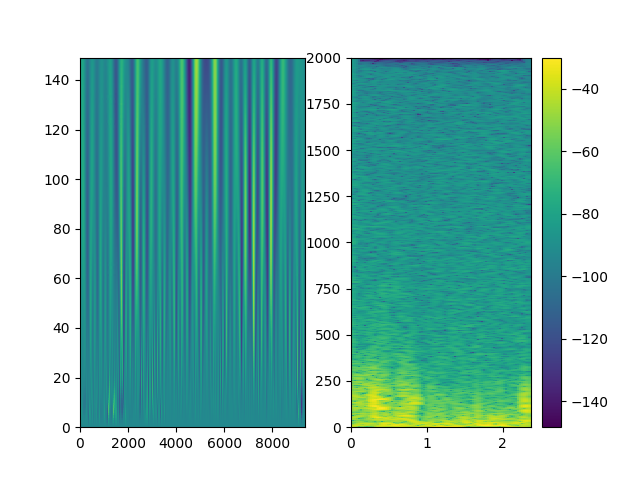

In [32]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.pcolormesh(coefs)

plt.subplot(1,2,2)
plt.pcolormesh(t,f,20*np.log10(abs(S)))
plt.colorbar()
plt.show()

In [29]:
print(S.shape)

(513, 62)
